# Anomaly Detection on PC7000 Excavator Data

This notebook demonstrates a machine learning experiment for anomaly detection on synthetic PC7000 excavator data. We will generate synthetic data, visualize it, preprocess, train an Isolation Forest model, evaluate its performance, and detect anomalies in new data.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Generate Synthetic PC7000 Excavator Data
np.random.seed(42)
n_samples = 1000
operating_hours = np.random.uniform(1000, 20000, n_samples)
load = np.random.uniform(0.5, 1.5, n_samples)
avg_temp = np.random.uniform(20, 80, n_samples)
vibration = np.random.uniform(0.1, 2.0, n_samples)
maintenance_count = np.random.randint(0, 10, n_samples)

# Inject anomalies
n_anomalies = 30
anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
operating_hours[anomaly_indices] = np.random.uniform(21000, 25000, n_anomalies)
load[anomaly_indices] = np.random.uniform(2.0, 3.0, n_anomalies)
avg_temp[anomaly_indices] = np.random.uniform(90, 120, n_anomalies)
vibration[anomaly_indices] = np.random.uniform(2.5, 4.0, n_anomalies)
maintenance_count[anomaly_indices] = np.random.randint(15, 25, n_anomalies)

# Create DataFrame
data = pd.DataFrame({
    'OperatingHours': operating_hours,
    'Load': load,
    'AvgTemp': avg_temp,
    'Vibration': vibration,
    'MaintenanceCount': maintenance_count
})
data['is_anomaly'] = 0
data.loc[anomaly_indices, 'is_anomaly'] = 1
data.head()

,OperatingHours,Load,AvgTemp,Vibration,MaintenanceCount,is_anomaly
0,8116.262258,0.685133,35.702341,1.378136,9,0
1,19063.571822,1.041901,34.818728,1.613695,4,0
2,14907.884894,1.372946,74.375275,0.575889,4,0
3,12374.511200,1.232225,34.972772,1.287261,6,0
4,3964.354168,1.306561,36.316984,1.186317,3,0


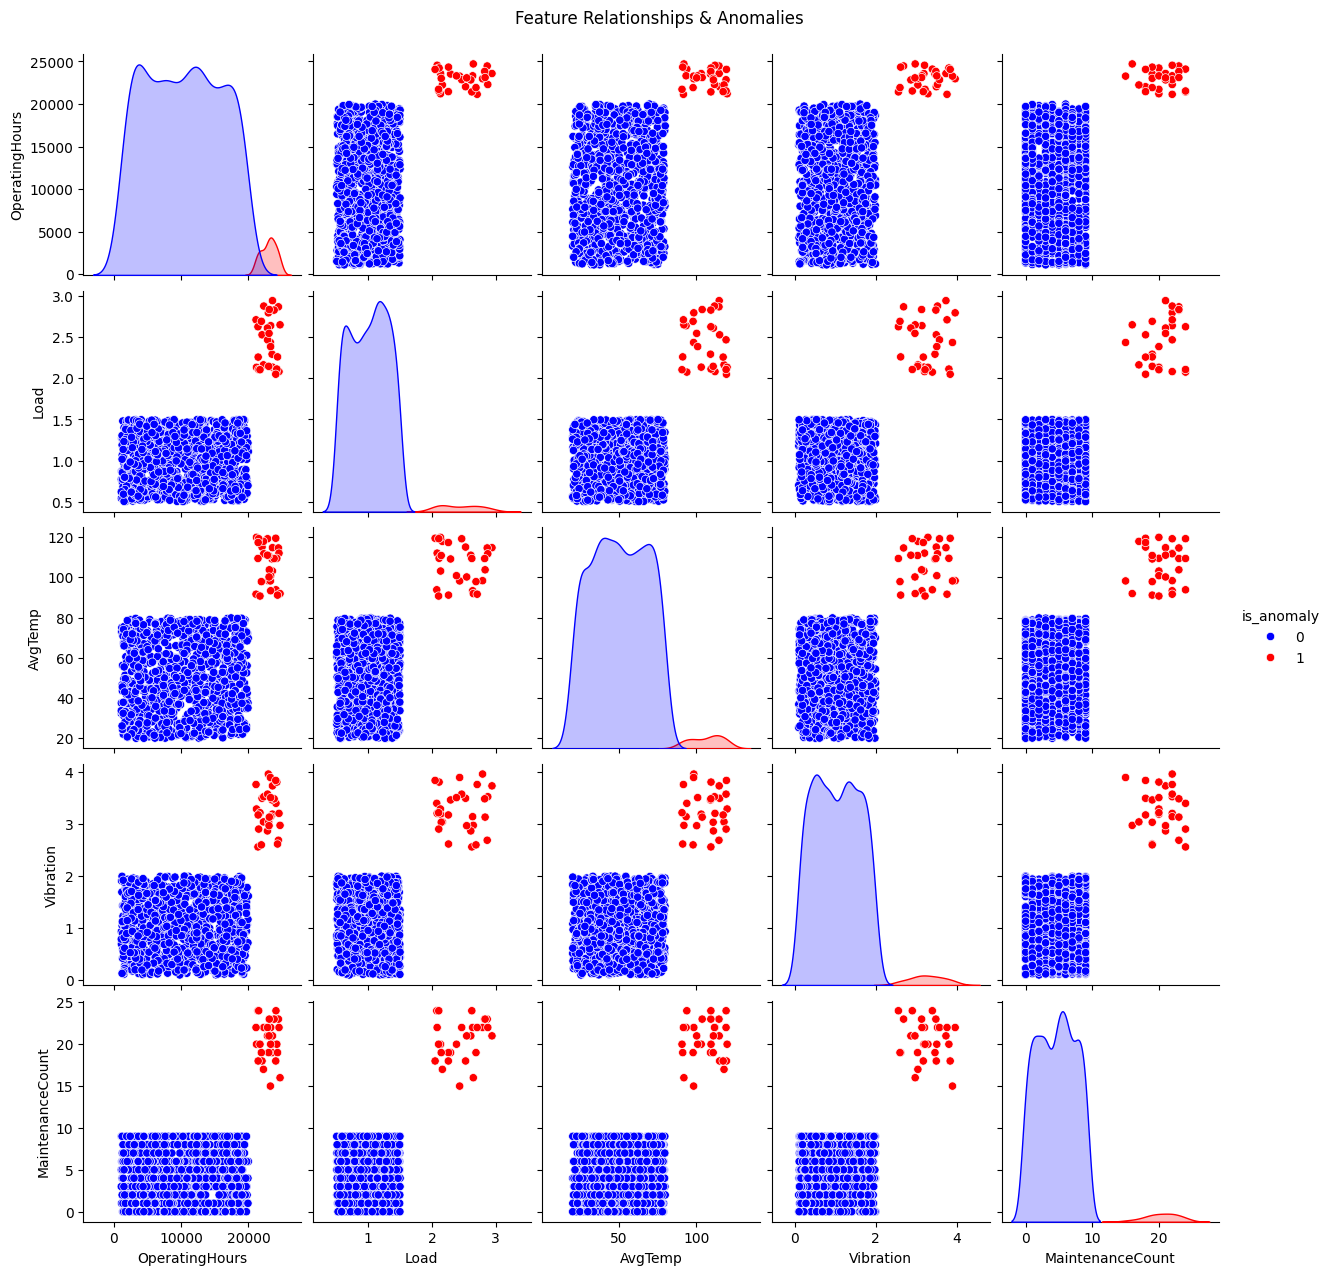

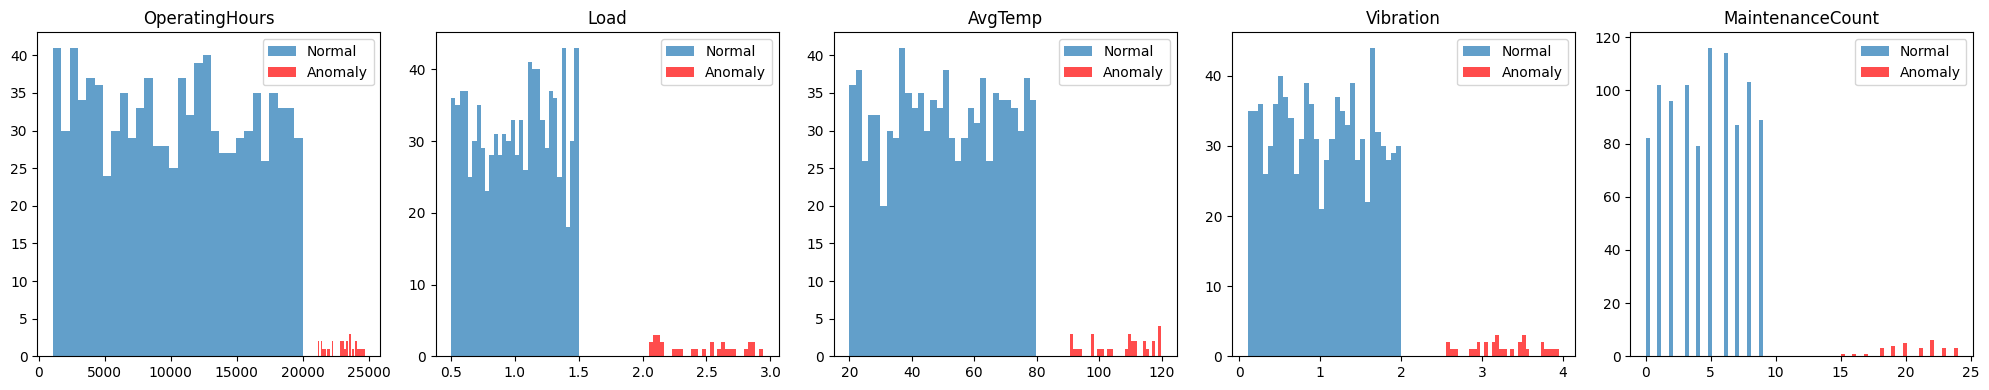

In [3]:
# Visualize Data Distributions
sns.pairplot(data, vars=['OperatingHours', 'Load', 'AvgTemp', 'Vibration', 'MaintenanceCount'], hue='is_anomaly', palette={0: 'blue', 1: 'red'})
plt.suptitle('Feature Relationships & Anomalies', y=1.02)
plt.show()

# Plot histograms for each feature
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, feature in enumerate(['OperatingHours', 'Load', 'AvgTemp', 'Vibration', 'MaintenanceCount']):
    axs[i].hist(data[feature][data['is_anomaly'] == 0], bins=30, alpha=0.7, label='Normal')
    axs[i].hist(data[feature][data['is_anomaly'] == 1], bins=30, alpha=0.7, label='Anomaly', color='red')
    axs[i].set_title(feature)
    axs[i].legend()
plt.tight_layout()
plt.show()

In [4]:
# Preprocess Data (Scaling & Cleaning)
features = ['OperatingHours', 'Load', 'AvgTemp', 'Vibration', 'MaintenanceCount']
print('Missing values per column:')
print(data[features].isnull().sum())

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

Missing values per column:
OperatingHours      0
Load                0
AvgTemp             0
Vibration           0
MaintenanceCount    0
dtype: int64


In [5]:
# Train-Test Split
X = data[features]
y = data['is_anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

Training samples: 800, Testing samples: 200


In [6]:
# Train Anomaly Detection Model (Isolation Forest)
iso_forest = IsolationForest(n_estimators=100, contamination=n_anomalies/n_samples, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on test set
anomaly_scores = iso_forest.decision_function(X_test)
y_pred = iso_forest.predict(X_test)
# Convert predictions: -1 = anomaly, 1 = normal
pred_labels = np.where(y_pred == -1, 1, 0)

Confusion Matrix:
[[191   1]
 [  0   8]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       192
     Anomaly       0.89      1.00      0.94         8

    accuracy                           0.99       200
   macro avg       0.94      1.00      0.97       200
weighted avg       1.00      0.99      1.00       200



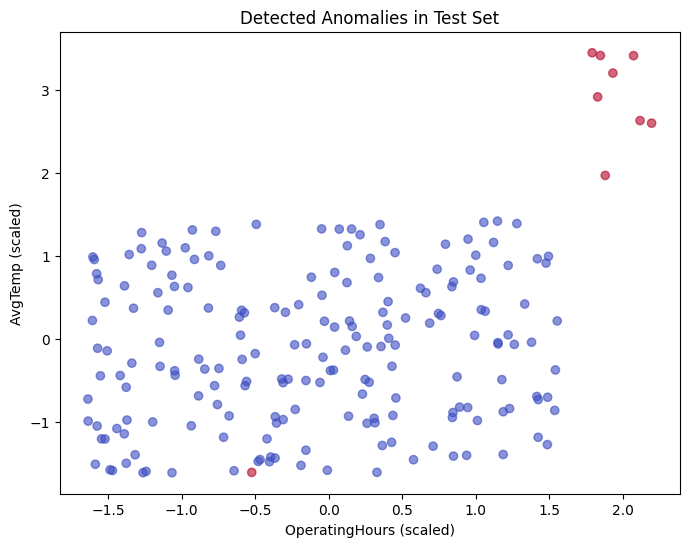

In [7]:
# Evaluate Model Performance
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, pred_labels))
print('\nClassification Report:')
print(classification_report(y_test, pred_labels, target_names=['Normal', 'Anomaly']))

# Visualize detected anomalies
plt.figure(figsize=(8,6))
plt.scatter(X_test['OperatingHours'], X_test['AvgTemp'], c=pred_labels, cmap='coolwarm', alpha=0.6)
plt.xlabel('OperatingHours (scaled)')
plt.ylabel('AvgTemp (scaled)')
plt.title('Detected Anomalies in Test Set')
plt.show()

In [8]:
# Detect Anomalies in New Data Examples
new_data = pd.DataFrame({
    'OperatingHours': [5000, 22000],
    'Load': [1.0, 2.5],
    'AvgTemp': [40, 110],
    'Vibration': [0.5, 3.5],
    'MaintenanceCount': [2, 18]
})
new_data[features] = scaler.transform(new_data[features])
pred_new = iso_forest.predict(new_data[features])
for i, label in enumerate(pred_new):
    status = 'Anomaly' if label == -1 else 'Normal'
    print(f'Example {i+1}: Predicted status = {status}')

Example 1: Predicted status = Normal
Example 2: Predicted status = Anomaly
